In [2]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"

In [4]:
import numpy as np

In [6]:
#import theano as th

In [8]:
#import theano.tensor as T

In [10]:
from keras.utils import np_utils
import keras.models as model

In [11]:
from keras.layers import Input,merge

In [13]:
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten#,MaxoutDense

In [14]:
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
#import cPickle, random, sys, keras
import random, sys, keras
from keras.models import Model
from IPython import display

In [17]:
sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

K.set_image_dim_ordering('th')

In [43]:

img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [44]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [45]:

shp = X_train.shape[1:]
print(shp)

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
nch = 200

(1, 28, 28)


In [47]:
# Build Generative model ...
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)

H = BatchNormalization()(H)

H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)


H = Convolution2D(int(nch/2), 3, 3, border_mode='same', init='glorot_uniform')(H)

H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(int(nch/4), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(39200, kernel_initializer="glorot_normal")`
  '` call to the Keras 2 API: ' + signature)
C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (3, 3), padding="same", kernel_initializer="glorot_uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (3, 3), padding="same", kernel_initializer="glorot_uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform")`
  '` call to the Keras 2 API: ' + signature)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_9 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_11 (Activation)   (None, 39200)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 200, 28, 28)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 28, 28)       180100    
__________

In [48]:
# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), strides=(2, 2), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
C:\Program Files\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), strides=(2, 2), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 14, 14)       6656      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 14, 14)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 14, 14)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 7, 7)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512, 7, 7)         0         
__________

In [49]:
# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 1, 28, 28)         4341425   
_________________________________________________________________
model_3 (Model)              (None, 2)                 9707266   
Total params: 14,048,691.0
Trainable params: 4,262,913.0
Non-trainable params: 9,785,778.0
_________________________________________________________________


In [50]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [51]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [52]:
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

In [53]:
make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=32)
y_hat = discriminator.predict(X)

C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py:1393: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
20000/20000 [==============================] - 566s - loss: 0.0054   


In [55]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

Accuracy: 100.00 pct (20000 of 20000) right


In [56]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [57]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

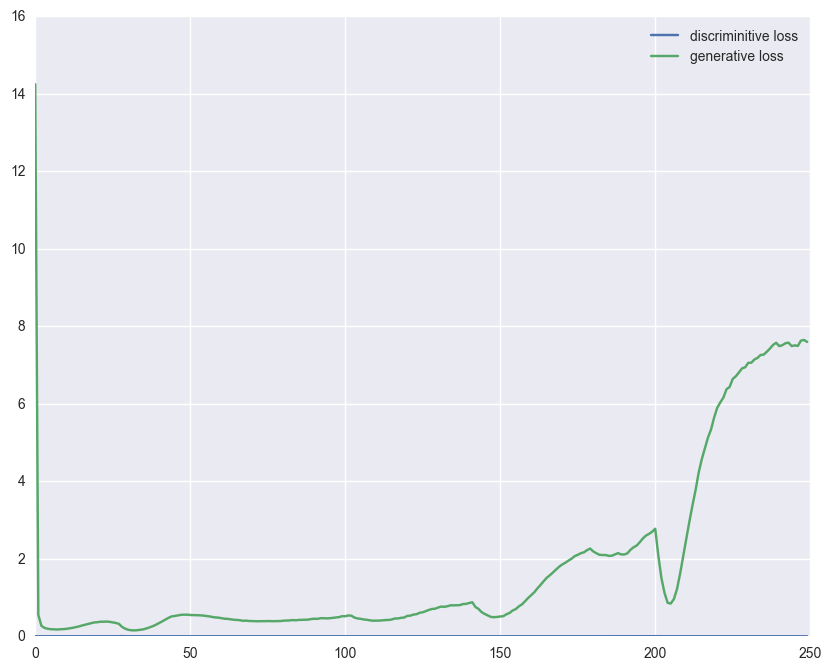

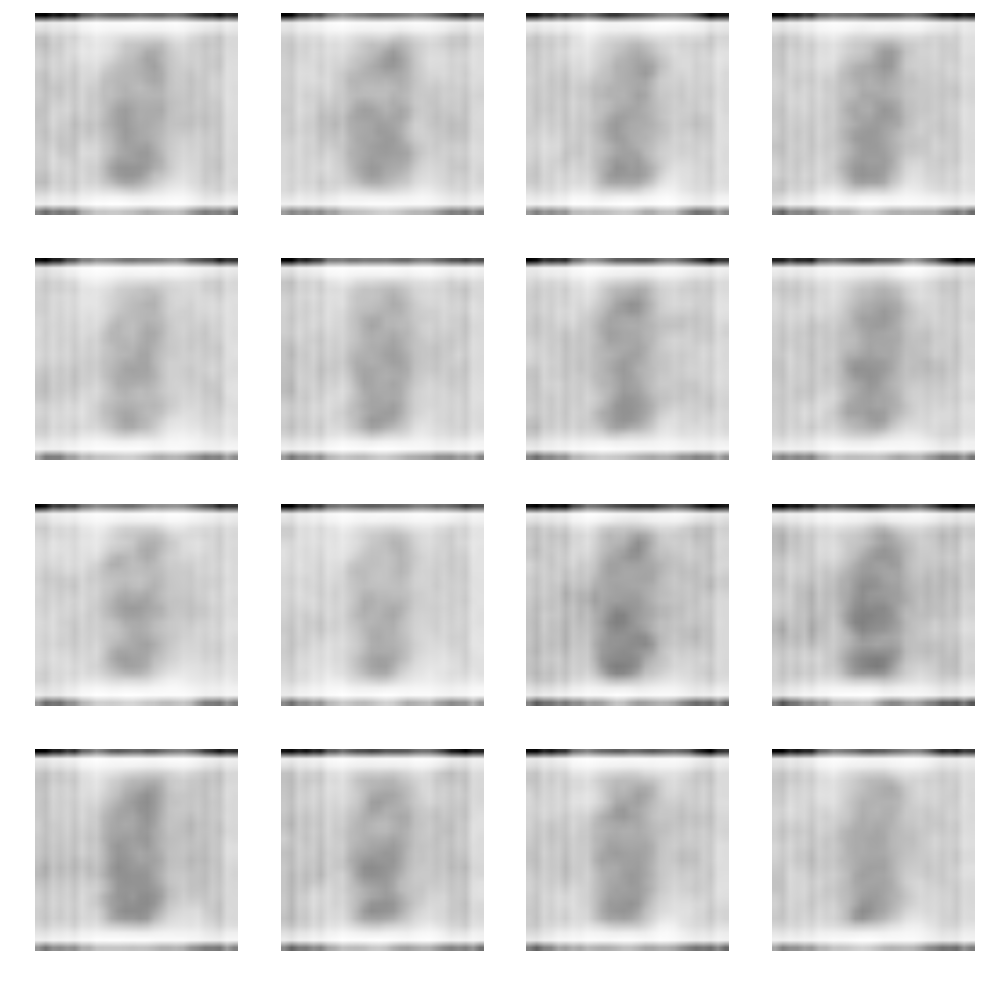

100%|██████████████████████████████████████| 250/250 [1:11:58<00:00, 17.64s/it]


In [58]:
train_for_n(nb_epoch=250, plt_frq=25,BATCH_SIZE=128)

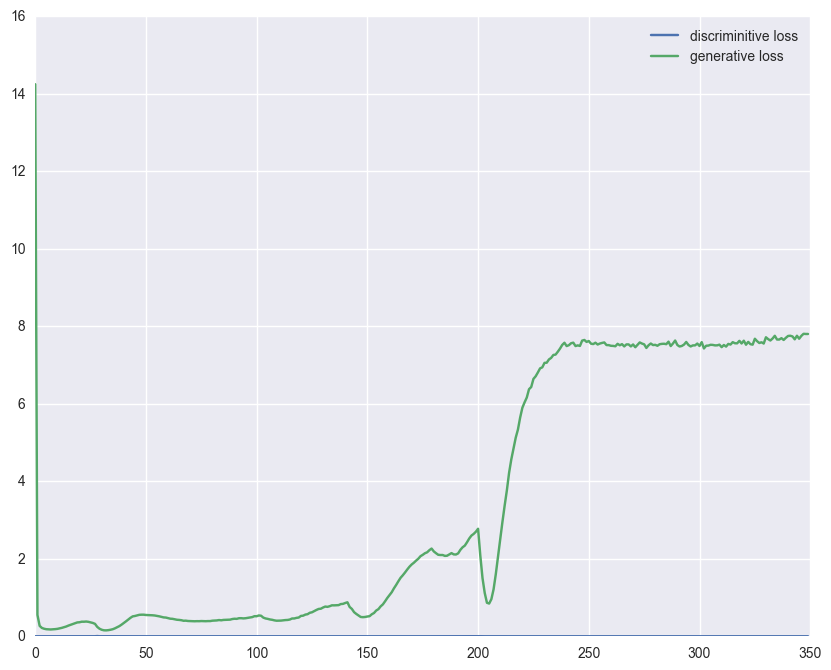

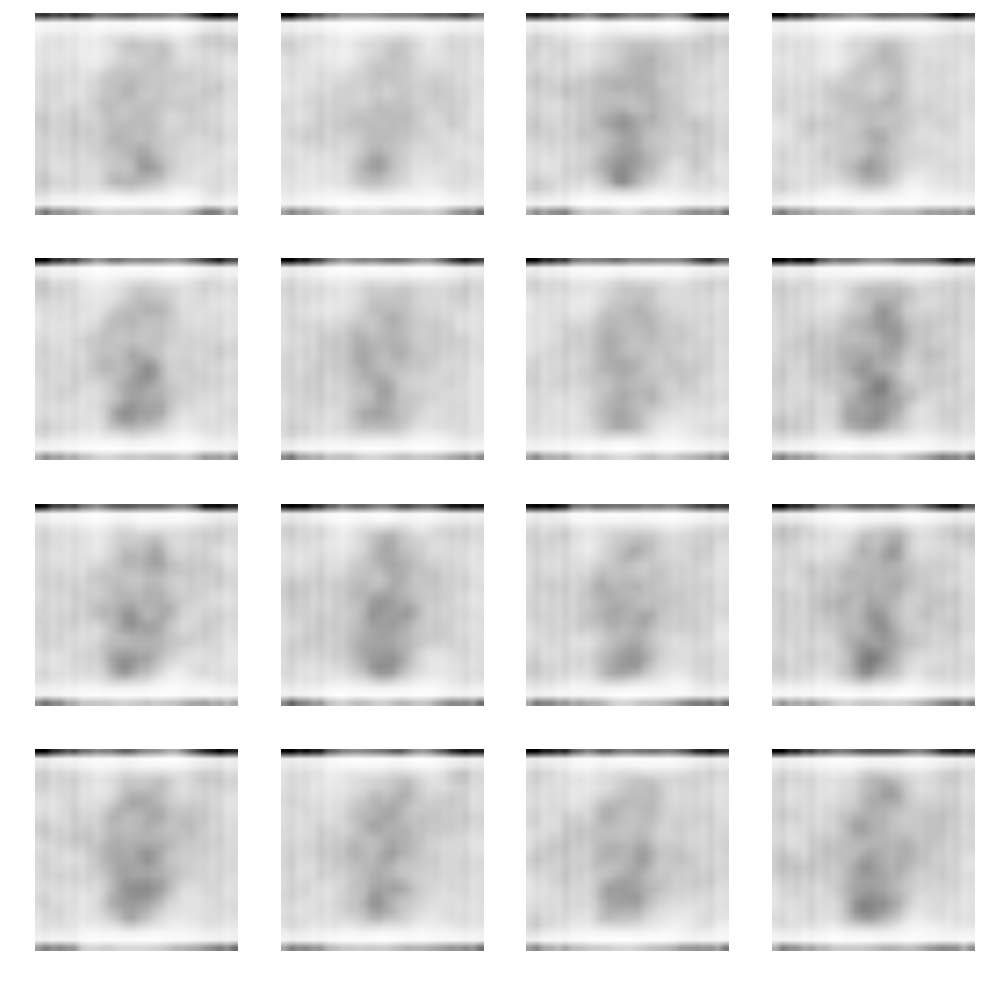

100%|████████████████████████████████████████| 100/100 [28:03<00:00, 17.22s/it]


In [59]:

K.set_value(opt.lr, 1e-4)
K.set_value(dopt.lr, 1e-5)
train_for_n(nb_epoch=100, plt_frq=10,BATCH_SIZE=128)

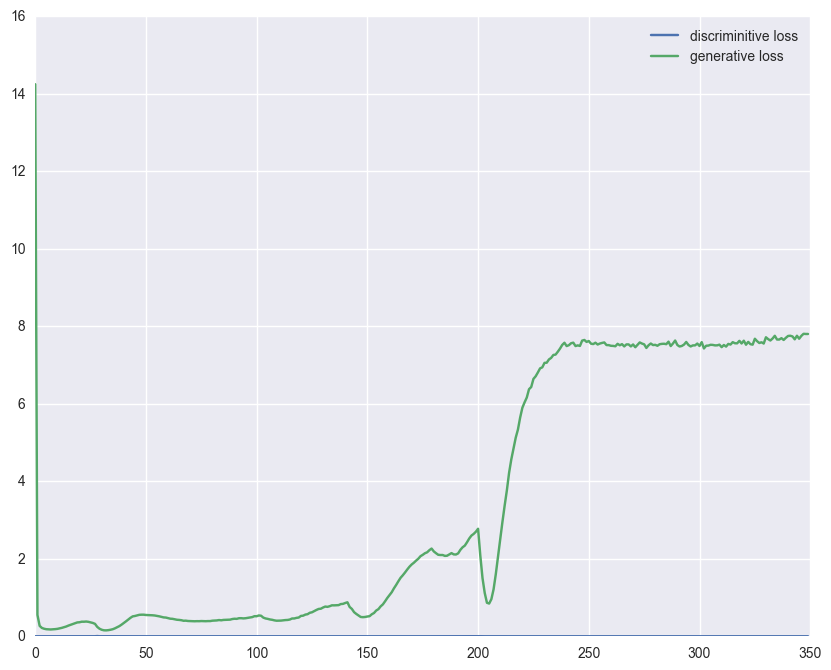

In [60]:
plot_loss(losses)

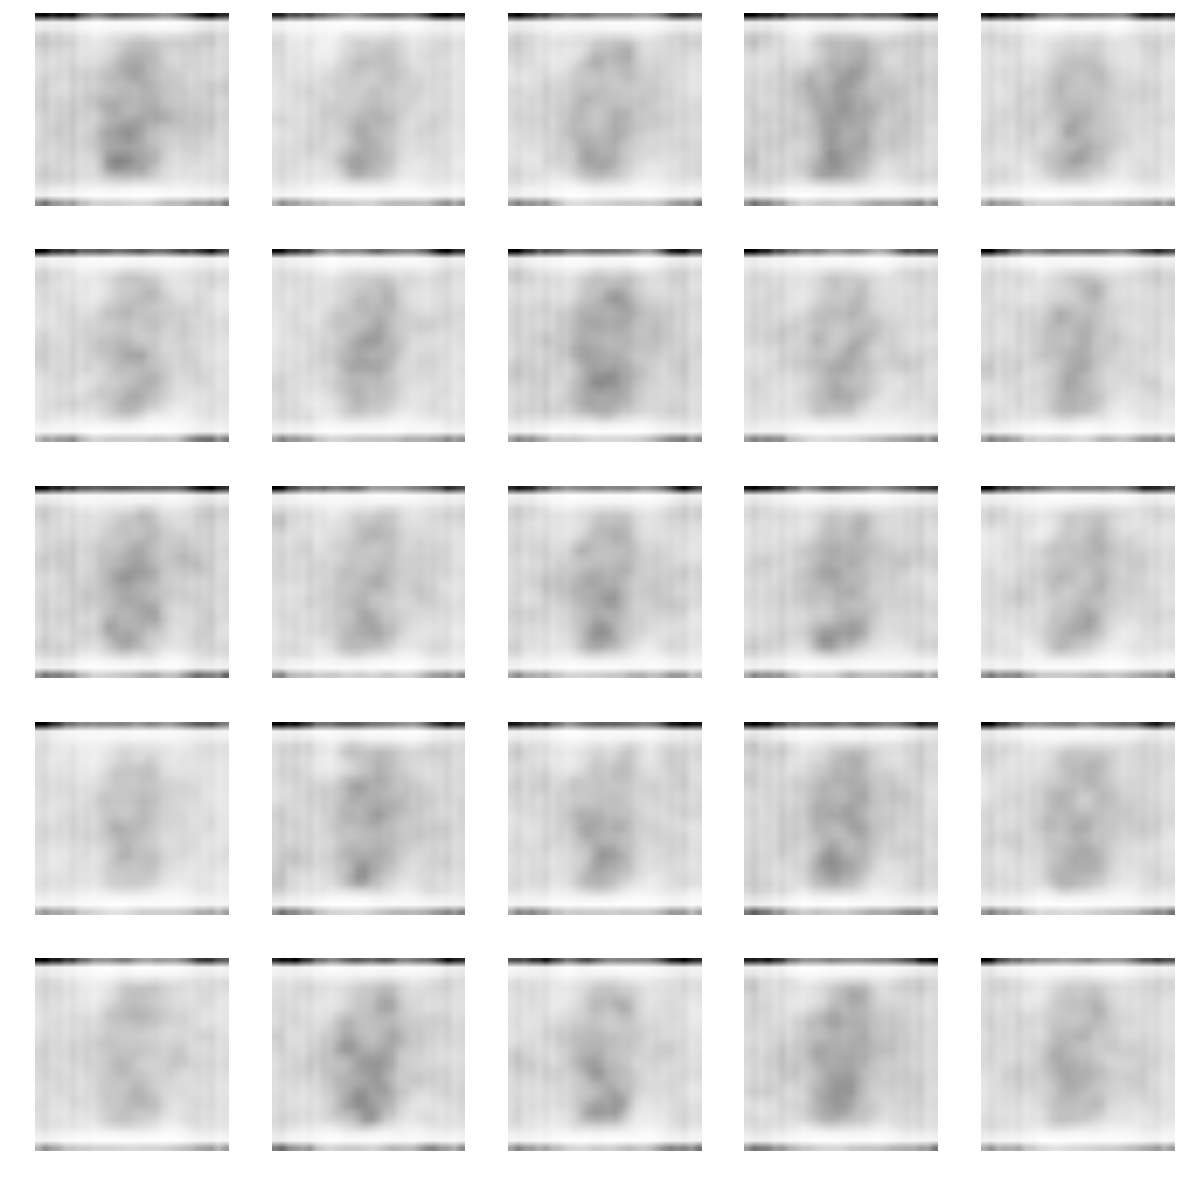

In [61]:
plot_gen(25,(5,5),(12,12))

In [62]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

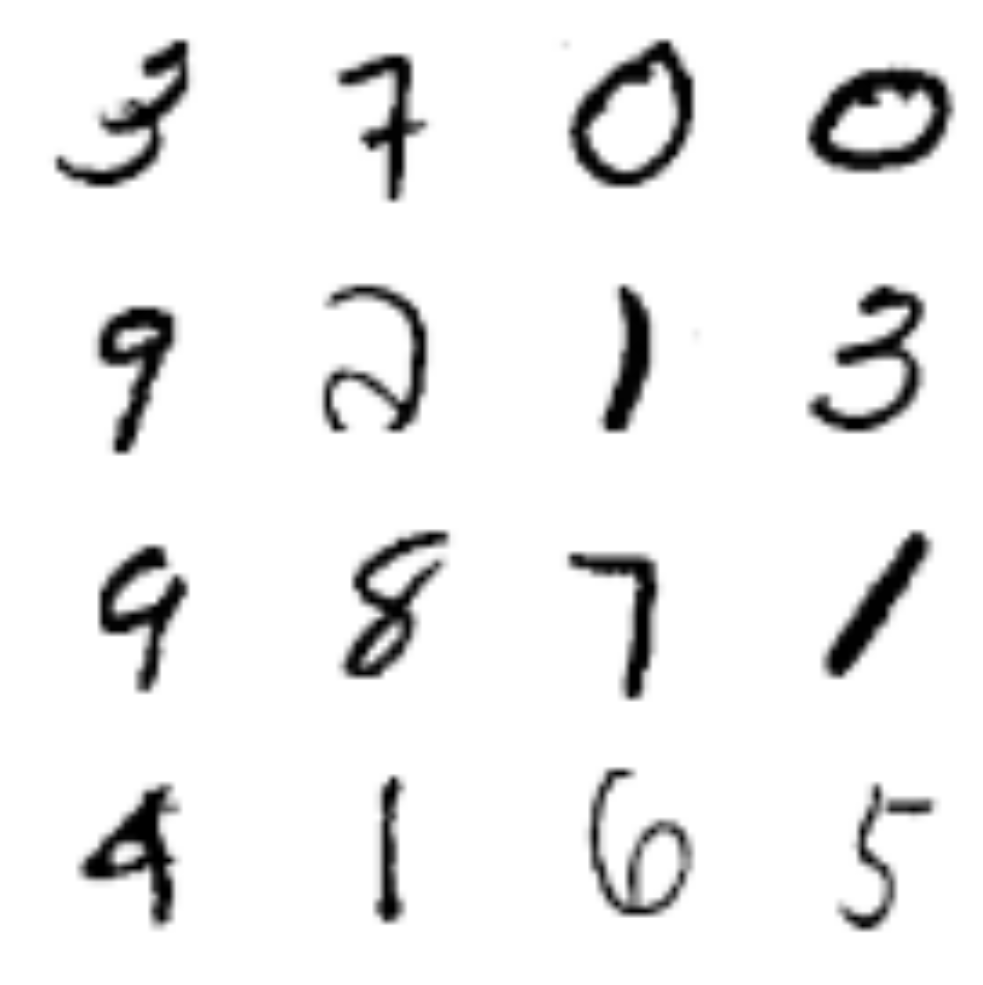

In [63]:
plot_real()